<a href="https://colab.research.google.com/github/lisa11323/BNPL/blob/main/ZINB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# 문제 있는 라인 무시하지 않고 CSV 파일 불러오기 (기본 동작)
df_merged_full = pd.read_csv('/content/df_with_interactions2.csv')

# 데이터 기본 정보 출력
print("데이터프레임 크기:", df_merged_full.shape)
print("\n처음 5행:")
print(df_merged_full.head())

print("\n데이터 타입 및 결측치 개수:")
print(df_merged_full.info())

print("\n결측치 개수 확인:")
print(df_merged_full.isnull().sum())

print("\n중복 행 개수:")
print(df_merged_full.duplicated().sum())

print("\n기초 통계량:")
print(df_merged_full.describe())

# 토픽 컬럼들만 추출해서 기초 통계 다시 확인
topic_cols = [col for col in df_merged_full.columns if 'Topic' in col]
print("\n토픽 컬럼들 기초 통계:")
print(df_merged_full[topic_cols].describe())

데이터프레임 크기: (65323, 38)

처음 5행:
                  Date      User Name  Score  \
0  2025-04-08 06:00:27  A Google user      1   
1  2025-04-08 05:28:15  A Google user      1   
2  2025-04-08 05:25:41  A Google user      1   
3  2025-04-08 05:06:36  A Google user      2   
4  2025-04-08 04:51:24  A Google user      1   

                                 Review_preprocessed  Helpful Votes  \
0  This is a sad story of a application, I used t...              0   
1  closed my son's account for no reason. been ov...              0   
2  took my check cashing away for no reason. won'...              0   
3  was really useful now it refuses to take my pi...              0   
4  the app is fine but for some reason it got mes...              0   

           App   Topic_1   Topic_2   Topic_3   Topic_4  ...  \
0  cashapp = 2  0.019501  0.019504  0.759066  0.019501  ...   
1  cashapp = 2  0.157061  0.030877  0.030877  0.030879  ...   
2    venmo = 1  0.286612  0.037892  0.037892  0.037893  ...   
3

In [ ]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
from sklearn.preprocessing import StandardScaler
import pandas as pd

# CSV 불러오기
# df_merged_full = pd.read_csv('/content/df_merged_full.csv')

# 종속 변수
y = df_merged_full['Helpful Votes']

# 스케일러 (Count 부분만 적용)
scaler = StandardScaler()

def fit_zinb(count_vars, infl_vars, model_name):
    # Count part (스케일링 적용)
    X_count = df_merged_full[count_vars]
    X_count_scaled = pd.DataFrame(
        scaler.fit_transform(X_count),
        columns=X_count.columns,
        index=X_count.index
    )
    X_count_scaled = sm.add_constant(X_count_scaled, prepend=False)

    # Inflation part (스케일링 없이)
    if infl_vars:
        X_infl = df_merged_full[infl_vars].copy()
        X_infl = sm.add_constant(X_infl, prepend=False)
    else:
        X_infl = pd.DataFrame({'const': [1]*len(y)})

    # 모델 적합 + 로버스트 표준오차(HC0)
    model = ZeroInflatedNegativeBinomialP(
        endog=y,
        exog=X_count_scaled,
        exog_infl=X_infl,
        inflation='logit'
    )
    result = model.fit(method="bfgs", maxiter=500, disp=0, cov_type='HC0')

    return {
        "Model": model_name,
        "LogLik": result.llf,
        "AIC": result.aic,
        "BIC": result.bic,
        "Params": result.params,
        "Robust_SE": result.bse
    }

# -----------------------
# 모델 변수 설정
# -----------------------
count_base = [
    'Score',
    'polarity',
    'subjectivity',
    'word_count_normalized',
    'Score_x_subjectivity',
    'polarity_x_subjectivity',
    'word_count_normalized_x_subjectivity'
]

count_vader = count_base + ['vader_compound']

infl_vars = [
    'Topic_1', 'Topic_2', 'Topic_3', 'Topic_5', 'Topic_6',
    'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11'
] + [
    f'Topic_{i}_x_subjectivity' for i in [1,2,3,5,6,7,8,9,10,11]
]

# -----------------------
# 모델 적합
# -----------------------
baseline = fit_zinb(count_base, infl_vars, "Baseline")
vader_model = fit_zinb(count_vader, infl_vars, "Vader Included")

# -----------------------
# 결과 확인
# -----------------------
results_df = pd.DataFrame([
    {
        "Model": baseline["Model"],
        "LogLik": baseline["LogLik"],
        "AIC": baseline["AIC"],
        "BIC": baseline["BIC"]
    },
    {
        "Model": vader_model["Model"],
        "LogLik": vader_model["LogLik"],
        "AIC": vader_model["AIC"],
        "BIC": vader_model["BIC"]
    }
])

print(results_df)

# 베이스라인 모델 파라미터 및 로버스트 표준오차
print("\nBaseline Params & Robust SE:")
print(pd.DataFrame({"coef": baseline["Params"], "robust_SE": baseline["Robust_SE"]}))

# Vader 모델 파라미터 및 로버스트 표준오차
print("\nVader Included Params & Robust SE:")
print(pd.DataFrame({"coef": vader_model["Params"], "robust_SE": vader_model["Robust_SE"]}))

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3938: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


            Model        LogLik            AIC            BIC
0        Baseline -72734.577949  145529.155899  145801.768883
1  Vader Included -72639.080711  145340.161421  145621.861505

Baseline Params & Robust SE:
                                           coef  robust_SE
inflate_Topic_1                       -1.401229   1.223759
inflate_Topic_2                       -1.226449   2.667861
inflate_Topic_3                       -0.767470   0.453325
inflate_Topic_5                       -0.941213   0.709998
inflate_Topic_6                       -0.904894   0.448191
inflate_Topic_7                       -0.635434   0.879839
inflate_Topic_8                       -0.846694   1.006449
inflate_Topic_9                       -2.653290   4.883261
inflate_Topic_10                      -0.788080   1.225763
inflate_Topic_11                      -0.670991   2.307857
inflate_Topic_1_x_subjectivity        -0.696781   0.693357
inflate_Topic_2_x_subjectivity        -0.627253   2.216702
inflate_Topic_3_x

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# 종속 변수
y = df_merged_full['Helpful Votes']

# 독립 변수
independent_vars = [
    'Score', 'polarity', 'subjectivity', 'word_count_normalized',
    'Score_x_subjectivity', 'polarity_x_subjectivity', 'word_count_normalized_x_subjectivity',
    'Topic_1', 'Topic_2', 'Topic_3', 'Topic_5', 'Topic_6',
    'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11',
    'Topic_1_x_subjectivity', 'Topic_2_x_subjectivity', 'Topic_3_x_subjectivity',
    'Topic_5_x_subjectivity', 'Topic_6_x_subjectivity', 'Topic_7_x_subjectivity',
    'Topic_8_x_subjectivity', 'Topic_9_x_subjectivity', 'Topic_10_x_subjectivity',
    'Topic_11_x_subjectivity'
]

X = df_merged_full[independent_vars]

# 표준화
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# 절편 추가
X_scaled = sm.add_constant(X_scaled, prepend=False)

# Negative Binomial 회귀 적합
model_nb = sm.GLM(y, X_scaled, family=sm.families.NegativeBinomial())
result_nb = model_nb.fit()

# 결과 출력
print(result_nb.summary())

# 로그우도, AIC, BIC 계산
loglik = result_nb.llf
aic = result_nb.aic
k = len(result_nb.params)  # 파라미터 개수
n = result_nb.nobs          # 표본 수
bic = -2 * loglik + k * np.log(n)

print(f"\nLog-Likelihood: {loglik:.3f}")
print(f"AIC: {aic:.3f}")
print(f"BIC: {bic:.3f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          Helpful Votes   No. Observations:                65323
Model:                            GLM   Df Residuals:                    65295
Model Family:        NegativeBinomial   Df Model:                           27
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87446.
Date:                Fri, 15 Aug 2025   Deviance:                       97666.
Time:                        03:34:22   Pearson chi2:                 1.54e+06
No. Iterations:                    21   Pseudo R-squ. (CS):             0.8978
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [ ]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
import pandas as pd
from sklearn.preprocessing import StandardScaler

# df_merged_full 데이터프레임이 준비되었다고 가정합니다.

# 독립 변수 정의
independent_vars_full = ['Score', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5',
            'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11',
            'polarity', 'subjectivity', 'word_count_normalized']

# 종속 변수
y = df_merged_full['Helpful Votes']

# 카운트 모델에 사용할 독립 변수
count_vars = ['Score', 'polarity', 'subjectivity', 'word_count_normalized']
X_count = df_merged_full[count_vars]

# 제로-인플레이션 모델에 사용할 독립 변수
infl_vars = ['Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6','Topic_7'
             , 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11']
X_infl = df_merged_full[infl_vars]

# --- 변수 표준화 ---
scaler_count = StandardScaler()
scaler_infl = StandardScaler()

X_count_scaled = pd.DataFrame(scaler_count.fit_transform(X_count), columns=X_count.columns, index=X_count.index)
X_infl_scaled = pd.DataFrame(scaler_infl.fit_transform(X_infl), columns=X_infl.columns, index=X_infl.index)

# 절편(constant) 추가
X_count_scaled = sm.add_constant(X_count_scaled, prepend=False)
X_infl_scaled = sm.add_constant(X_infl_scaled, prepend=False)

# --- 모델 적합 ---
model = ZeroInflatedNegativeBinomialP(endog=y, exog=X_count_scaled, exog_infl=X_infl_scaled, inflation='logit')
result = model.fit(method="bfgs", maxiter=1000, disp=1)

# 결과 출력
print(result.summary())

# 로그우도, AIC, BIC 출력
print(f"\nLog-Likelihood: {result.llf:.3f}")
print(f"AIC: {result.aic:.3f}")
print(f"BIC: {result.bic:.3f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3938: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 1.114904
         Iterations: 133
         Function evaluations: 138
         Gradient evaluations: 138


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                     Helpful Votes   No. Observations:                65323
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    65318
Method:                                      MLE   Df Model:                            4
Date:                           Mon, 11 Aug 2025   Pseudo R-squ.:                  0.1486
Time:                                   14:07:39   Log-Likelihood:                -72829.
converged:                                  True   LL-Null:                       -85542.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
inflate_Topic_2          -0.1377      0.619     -0.223      0.824      -1.350       1.075
inflate_To

In [ ]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 종속 변수
y = df_merged_full['Helpful Votes']

# 카운트 모델에 사용할 독립 변수
count_vars = [
    'Score',
    'polarity',
    'subjectivity',
    'word_count_normalized',
    'Score_x_subjectivity',
    'polarity_x_subjectivity',
    'word_count_normalized_x_subjectivity'

]
X_count = df_merged_full[count_vars]

# 제로-인플레이션 모델에 사용할 독립 변수
infl_vars = ['Topic_1', 'Topic_2', 'Topic_3',  'Topic_5', 'Topic_6',
              'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11', 'Topic_1_x_subjectivity', 'Topic_2_x_subjectivity', 'Topic_3_x_subjectivity',   'Topic_5_x_subjectivity',
 'Topic_6_x_subjectivity', 'Topic_7_x_subjectivity', 'Topic_8_x_subjectivity', 'Topic_9_x_subjectivity','Topic_10_x_subjectivity','Topic_11_x_subjectivity']

X_infl = df_merged_full[infl_vars]

# 변수 표준화
scaler_count = StandardScaler()
scaler_infl = StandardScaler()

X_count_scaled = pd.DataFrame(scaler_count.fit_transform(X_count), columns=X_count.columns, index=X_count.index)
X_infl_scaled = pd.DataFrame(scaler_infl.fit_transform(X_infl), columns=X_infl.columns, index=X_infl.index)

# 절편 추가
X_count_scaled = sm.add_constant(X_count_scaled, prepend=False)
X_infl_scaled = sm.add_constant(X_infl_scaled, prepend=False)

# 모델 적합 (ZIP)
model_zip = ZeroInflatedPoisson(endog=y, exog=X_count_scaled, exog_infl=X_infl_scaled, inflation='logit')
result_zip = model_zip.fit(method="bfgs", maxiter=1000, disp=1)

# 결과 출력
print(result_zip.summary())

# 로그우도, AIC, BIC 출력
print(f"\nLog-Likelihood: {result_zip.llf:.3f}")
print(f"AIC: {result_zip.aic:.3f}")
print(f"BIC: {result_zip.bic:.3f}")

Optimization terminated successfully.
         Current function value: 7.991373
         Iterations: 46
         Function evaluations: 50
         Gradient evaluations: 50
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:           Helpful Votes   No. Observations:                65323
Model:             ZeroInflatedPoisson   Df Residuals:                    65315
Method:                            MLE   Df Model:                            7
Date:                 Fri, 15 Aug 2025   Pseudo R-squ.:                  0.2670
Time:                         02:48:24   Log-Likelihood:            -5.2202e+05
converged:                        True   LL-Null:                   -7.1221e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
from sklearn.preprocessing import StandardScaler

# 종속변수
y = df_merged_full['Helpful Votes']

# 독립변수 설정
count_vars = [
    'Score',
    'polarity',
    'subjectivity',
    'word_count_normalized',
    'Score_x_subjectivity',
    'polarity_x_subjectivity',
    'word_count_normalized_x_subjectivity'

]

infl_vars = ['Topic_1', 'Topic_2', 'Topic_3',  'Topic_5', 'Topic_6',
              'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11', 'Topic_1_x_subjectivity', 'Topic_2_x_subjectivity', 'Topic_3_x_subjectivity',   'Topic_5_x_subjectivity',
 'Topic_6_x_subjectivity', 'Topic_7_x_subjectivity', 'Topic_8_x_subjectivity', 'Topic_9_x_subjectivity','Topic_10_x_subjectivity','Topic_11_x_subjectivity']

# 변수 데이터 프레임 준비
X_count = df_merged_full[count_vars]
X_infl = df_merged_full[infl_vars]

# 스케일링
scaler = StandardScaler()
X_count_scaled = pd.DataFrame(scaler.fit_transform(X_count), columns=X_count.columns, index=X_count.index)
X_infl_scaled = pd.DataFrame(scaler.fit_transform(X_infl), columns=X_infl.columns, index=X_infl.index)

# 절편 추
X_count_scaled = sm.add_constant(X_count_scaled, prepend=False)
X_infl_scaled = sm.add_constant(X_infl_scaled, prepend=False)

# 모델 적합
model = ZeroInflatedNegativeBinomialP(endog=y,
                                      exog=X_count_scaled,
                                      exog_infl=X_infl_scaled,
                                      inflation='logit')
result = model.fit(method='bfgs', maxiter=1000, disp=1)

# 결과 출력
print(result.summary())
print(f"\nLog-Likelihood: {result.llf:.3f}")
print(f"AIC: {result.aic:.3f}")
print(f"BIC: {result.bic:.3f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3938: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 1.112984
         Iterations: 252
         Function evaluations: 257
         Gradient evaluations: 257


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                     Helpful Votes   No. Observations:                65323
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    65315
Method:                                      MLE   Df Model:                            7
Date:                           Thu, 14 Aug 2025   Pseudo R-squ.:                  0.1501
Time:                                   16:18:42   Log-Likelihood:                -72703.
converged:                                  True   LL-Null:                       -85542.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
inflate_Topic_1                          0.1421     10.710      0.013 

In [ ]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 종속변수
y = df_merged_full['Helpful Votes']

# 독립변수 설정
count_vars = ['Score', 'polarity', 'subjectivity', 'word_count_normalized','Topic_1_x_Score', 'Topic_2_x_Score', 'Topic_3_x_Score', 'Topic_5_x_Score',
    'Topic_6_x_Score', 'Topic_7_x_Score', 'Topic_8_x_Score', 'Topic_10_x_Score']

infl_vars = [
    'Topic_1', 'Topic_2', 'Topic_3', 'Topic_5', 'Topic_6',
    'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11',
]

# 변수 데이터 프레임 준비
X_count = df_merged_full[count_vars]
X_infl = df_merged_full[infl_vars]

# 스케일링
scaler = StandardScaler()
X_count_scaled = pd.DataFrame(scaler.fit_transform(X_count), columns=X_count.columns, index=X_count.index)
X_infl_scaled = pd.DataFrame(scaler.fit_transform(X_infl), columns=X_infl.columns, index=X_infl.index)

# 절편 추가
X_count_scaled = sm.add_constant(X_count_scaled, prepend=False)
X_infl_scaled = sm.add_constant(X_infl_scaled, prepend=False)

# 모델 적합
model = ZeroInflatedNegativeBinomialP(
    endog=y,
    exog=X_count_scaled,
    exog_infl=X_infl_scaled,
    inflation='logit'
)
result = model.fit(method='bfgs', maxiter=1000, disp=1)

# 결과 출력
print(result.summary())
print(f"\nLog-Likelihood: {result.llf:.3f}")
print(f"AIC: {result.aic:.3f}")
print(f"BIC: {result.bic:.3f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 1.113017
         Iterations: 59
         Function evaluations: 62
         Gradient evaluations: 62


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                     Helpful Votes   No. Observations:                65323
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    65310
Method:                                      MLE   Df Model:                           12
Date:                           Tue, 12 Aug 2025   Pseudo R-squ.:                  0.1501
Time:                                   10:01:36   Log-Likelihood:                -72706.
converged:                                  True   LL-Null:                       -85542.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
inflate_Topic_1          -5.2120        nan        nan        nan         nan         nan
inflate_To

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_vif(df_vars):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_vars.columns
    vif_data["VIF"] = [variance_inflation_factor(df_vars.values, i)
                       for i in range(len(df_vars.columns))]
    return vif_data

check_vif(df_merged_full[infl_vars])

,feature,VIF
0,Topic_1,3.639345
1,Topic_2,3.249482
2,Topic_3,3.362265
3,Topic_4,4.434011
4,Topic_5,3.302964
5,Topic_6,3.844470
6,Topic_7,3.234592
7,Topic_8,2.903075
8,Topic_9,3.044861
9,Topic_10,3.862157


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# ===== 상호작용 변수 생성 =====
topic_cols = [col for col in df_merged_full.columns if col.startswith('Topic_')]
for col in topic_cols:
    df_merged_full[f"{col}_x_Score"] = df_merged_full[col] * df_merged_full['Score']

# ===== 분석할 변수 목록 =====
vars_all = ['Score', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5',
            'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11',
            'polarity', 'subjectivity', 'word_count_normalized'] #\
         #  + [f"{col}_x_Score" for col in topic_cols]

df_vars = df_merged_full[vars_all]

# ===== 상관계수 + p-value 하삼각만 =====
rows = []
for i in range(len(vars_all)):
    row_data = []
    for j in range(i+1):  # i까지 → 하삼각
        if i == j:
            row_data.append("1.0000 (0.0000)")
        else:
            r, p = pearsonr(df_vars[vars_all[i]], df_vars[vars_all[j]])
            row_data.append(f"{r:.4f} ({p:.4f})")
    rows.append(row_data)

# 데이터프레임 생성 (위쪽 잘린 하삼각)
corr_pval_lower = pd.DataFrame(rows, index=vars_all, columns=vars_all).fillna("")

print("상관계수 (p-value) 하삼각 행렬:")
corr_pval_lower

상관계수 (p-value) 하삼각 행렬:


,Score,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,polarity,subjectivity,word_count_normalized
Score,1.0000 (0.0000),,,,,,,,,,,,,,
Topic_1,0.0353 (0.0000),1.0000 (0.0000),,,,,,,,,,,,,
Topic_2,-0.0993 (0.0000),-0.0913 (0.0000),1.0000 (0.0000),,,,,,,,,,,,
Topic_3,0.0700 (0.0000),-0.0876 (0.0000),-0.0781 (0.0000),1.0000 (0.0000),,,,,,,,,,,
Topic_4,0.2434 (0.0000),-0.0970 (0.0000),-0.1180 (0.0000),-0.0838 (0.0000),1.0000 (0.0000),,,,,,,,,,
Topic_5,-0.0454 (0.0000),-0.1196 (0.0000),-0.0998 (0.0000),-0.0831 (0.0000),-0.1300 (0.0000),1.0000 (0.0000),,,,,,,,,
Topic_6,0.1437 (0.0000),-0.0602 (0.0000),-0.0984 (0.0000),-0.0630 (0.0000),-0.0837 (0.0000),-0.0924 (0.0000),1.0000 (0.0000),,,,,,,,
Topic_7,-0.0273 (0.0000),-0.0696 (0.0000),-0.0620 (0.0000),-0.0495 (0.0000),-0.0681 (0.0000),-0.0637 (0.0000),-0.0414 (0.0000),1.0000 (0.0000),,,,,,,
Topic_8,-0.0407 (0.0000),-0.1108 (0.0000),-0.0892 (0.0000),-0.0819 (0.0000),-0.1207 (0.0000),-0.0897 (0.0000),-0.0852 (0.0000),-0.0530 (0.0000),1.0000 (0.0000),,,,,,
Topic_9,-0.3114 (0.0000),-0.1616 (0.0000),-0.1213 (0.0000),-0.1340 (0.0000),-0.1974 (0.0000),-0.1388 (0.0000),-0.1633 (0.0000),-0.1286 (0.0000),-0.1541 (0.0000),1.0000 (0.0000),,,,,


            Topic_1       Topic_2       Topic_3       Topic_4       Topic_5  \
count  65323.000000  65323.000000  65323.000000  65323.000000  65323.000000   
mean       0.094960      0.087802      0.075557      0.099170      0.095179   
std        0.123224      0.113642      0.098849      0.134778      0.122108   
min        0.014343      0.014344      0.015800      0.014345      0.015182   
25%        0.029299      0.029041      0.028511      0.028654      0.029949   
50%        0.037735      0.037691      0.037656      0.037708      0.037749   
75%        0.090909      0.090909      0.071742      0.090909      0.090909   
max        0.783916      0.760168      0.767059      0.760263      0.782598   

            Topic_6       Topic_7       Topic_8       Topic_9      Topic_10  \
count  65323.000000  65323.000000  65323.000000  65323.000000  65323.000000   
mean       0.078942      0.064162      0.090741      0.146405      0.087076   
std        0.106457      0.080348      0.120294    

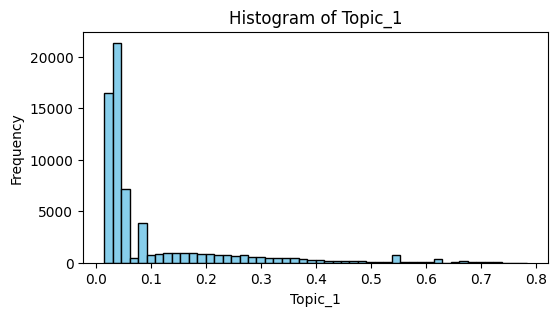

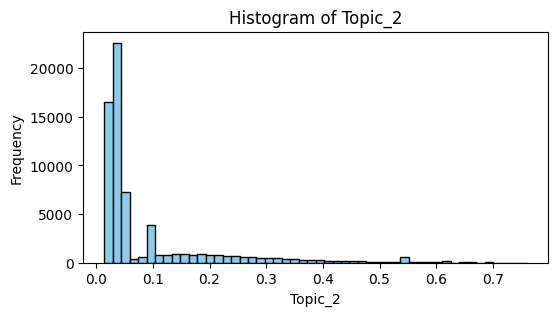

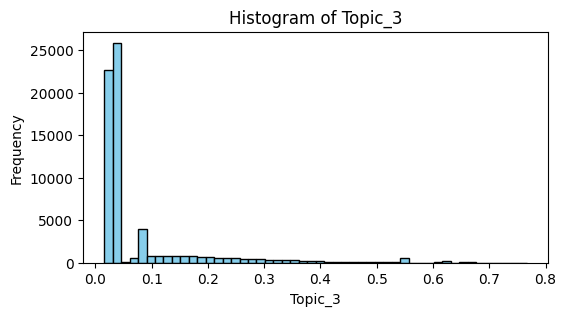

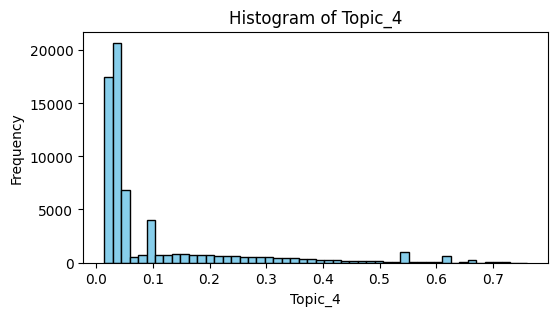

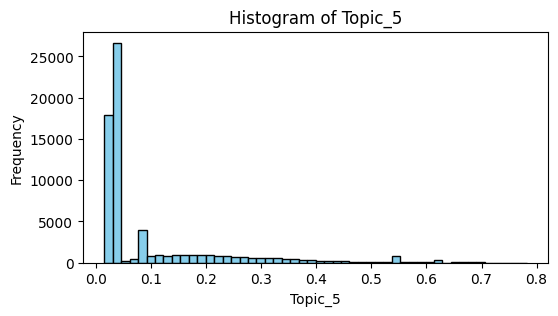

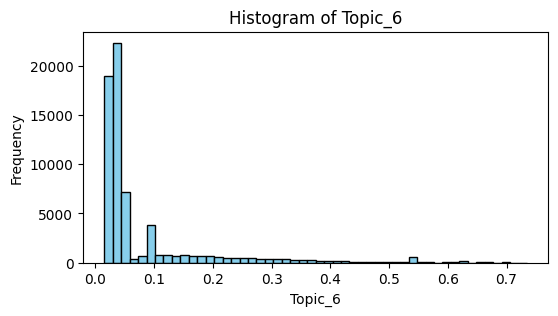

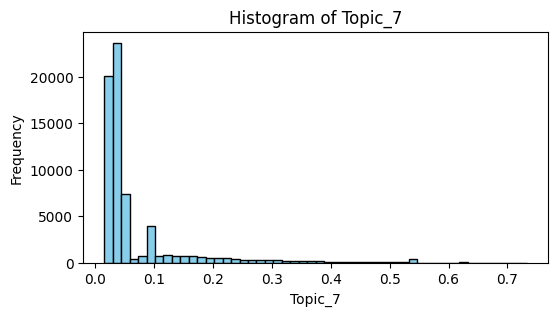

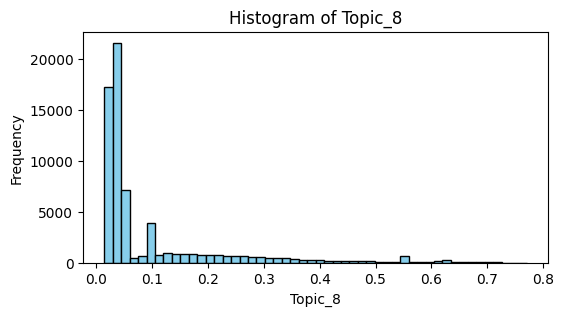

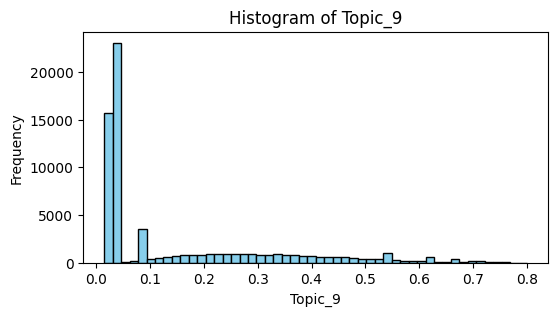

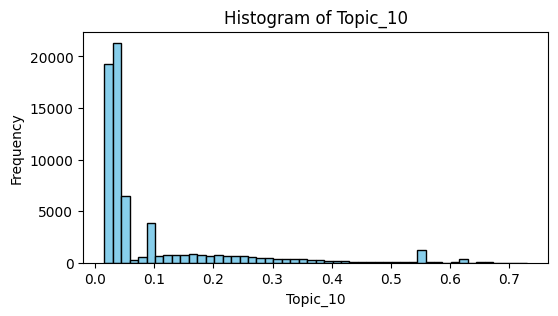

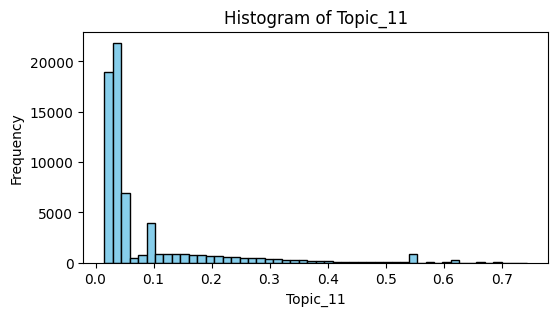

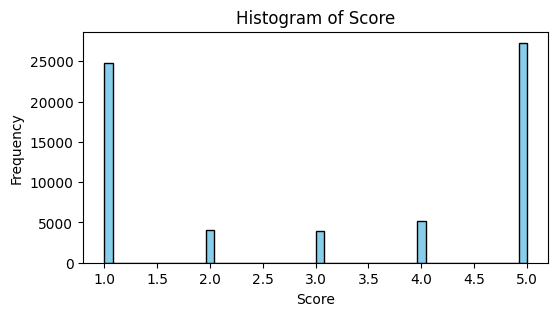

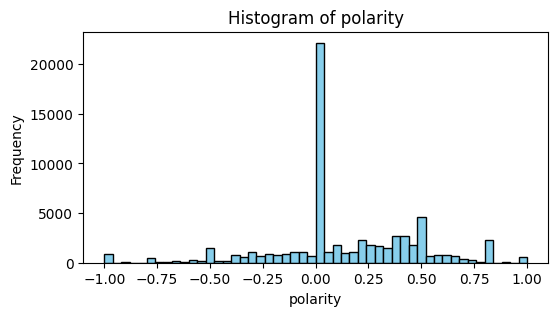

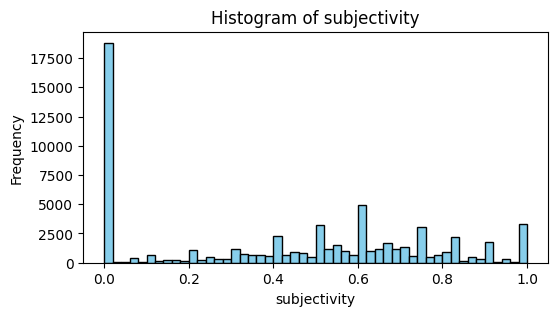

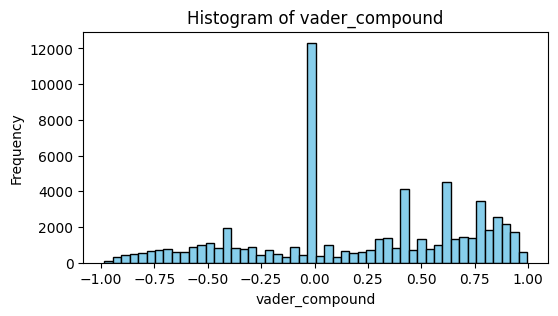

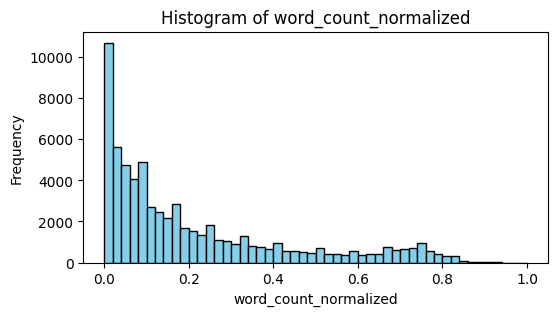

In [ ]:
import matplotlib.pyplot as plt

# 관심 변수들 (예: 토픽 변수 + 카운트 변수)
vars_to_check = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5',
                 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11',
                 'Score', 'polarity', 'subjectivity', 'vader_compound', 'word_count_normalized']

# 기초 통계
print(df_merged_full[vars_to_check].describe())

# 변수별 히스토그램
for var in vars_to_check:
    plt.figure(figsize=(6, 3))
    plt.hist(df_merged_full[var], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
for var in vars_to_check:
    Q1 = df_merged_full[var].quantile(0.25)
    Q3 = df_merged_full[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_merged_full[(df_merged_full[var] < lower_bound) | (df_merged_full[var] > upper_bound)]
    print(f'{var} 이상치 개수: {outliers.shape[0]} / 전체: {df_merged_full.shape[0]}')


Topic_1 이상치 개수: 10802 / 전체: 65323
Topic_2 이상치 개수: 9677 / 전체: 65323
Topic_3 이상치 개수: 9640 / 전체: 65323
Topic_4 이상치 개수: 11033 / 전체: 65323
Topic_5 이상치 개수: 11006 / 전체: 65323
Topic_6 이상치 개수: 9668 / 전체: 65323
Topic_7 이상치 개수: 13857 / 전체: 65323
Topic_8 이상치 개수: 9926 / 전체: 65323
Topic_9 이상치 개수: 2477 / 전체: 65323
Topic_10 이상치 개수: 9294 / 전체: 65323
Topic_11 이상치 개수: 7927 / 전체: 65323
Score 이상치 개수: 0 / 전체: 65323
polarity 이상치 개수: 1778 / 전체: 65323
subjectivity 이상치 개수: 0 / 전체: 65323
vader_compound 이상치 개수: 0 / 전체: 65323
word_count_normalized 이상치 개수: 4429 / 전체: 65323


In [ ]:
print(X_infl.describe())
print(X_infl.var())

            Topic_1       Topic_2       Topic_3       Topic_4       Topic_5  \
count  65323.000000  65323.000000  65323.000000  65323.000000  65323.000000   
mean       0.094960      0.087802      0.075557      0.099170      0.095179   
std        0.123224      0.113642      0.098849      0.134778      0.122108   
min        0.014343      0.014344      0.015800      0.014345      0.015182   
25%        0.029299      0.029041      0.028511      0.028654      0.029949   
50%        0.037735      0.037691      0.037656      0.037708      0.037749   
75%        0.090909      0.090909      0.071742      0.090909      0.090909   
max        0.783916      0.760168      0.767059      0.760263      0.782598   

            Topic_6       Topic_7       Topic_8       Topic_9      Topic_10  
count  65323.000000  65323.000000  65323.000000  65323.000000  65323.000000  
mean       0.078942      0.064162      0.090741      0.146405      0.087076  
std        0.106457      0.080348      0.120294      0

In [ ]:
X_count_scaled

,Score,polarity,subjectivity,vader_compound,word_count_normalized,const
0,-1.147716,-0.653057,0.723513,1.438501,2.297575,1.0
1,-1.147716,-0.653057,-0.984593,-0.415493,0.222305,1.0
2,-1.147716,-0.367087,-1.286023,0.167821,-0.575876,1.0
3,-0.599224,0.490823,-1.286023,-0.064913,-0.256604,1.0
4,-1.147716,-0.867535,-0.758520,-1.693661,-0.296513,1.0
...,...,...,...,...,...,...
65318,-0.599224,-0.367087,-1.286023,-0.415493,-0.855239,1.0
65319,-1.147716,-3.226788,1.728281,-0.908157,-0.256604,1.0
65320,-1.147716,-0.367087,-1.286023,-0.415493,-0.815330,1.0
65321,1.046251,0.347838,0.472321,0.415139,-0.735512,1.0


In [ ]:
X_infl_scaled

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,const
0,0.019501,0.019504,0.759066,0.019501,0.019501,0.019501,0.019501,0.019502,0.065422,0.019501,1.0
1,0.157061,0.030877,0.030877,0.030879,0.030879,0.030880,0.030879,0.565037,0.030877,0.030877,1.0
2,0.286612,0.037892,0.037892,0.037893,0.037893,0.037894,0.037893,0.037892,0.372355,0.037892,1.0
3,0.025267,0.136539,0.414711,0.025267,0.025268,0.025267,0.025267,0.161253,0.110625,0.025268,1.0
4,0.030614,0.229167,0.030614,0.030614,0.145982,0.379938,0.030614,0.030614,0.030616,0.030615,1.0
...,...,...,...,...,...,...,...,...,...,...,...
65318,0.045455,0.045455,0.045455,0.045455,0.045455,0.545455,0.045455,0.045455,0.045455,0.045455,1.0
65319,0.028335,0.028336,0.028335,0.277149,0.028336,0.204329,0.028335,0.028345,0.291829,0.028335,1.0
65320,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,1.0
65321,0.033451,0.266378,0.033451,0.432567,0.033451,0.033451,0.033451,0.033451,0.033451,0.033451,1.0


In [ ]:
print(X_infl.isnull().sum())
print(np.isfinite(X_infl).all())

# 2. 절편 중복 문제 방지
# 만약 X_infl에 const 컬럼 이미 있으면 sm.add_constant 빼기
if 'const' not in X_infl.columns:
    X_infl_scaled = sm.add_constant(X_infl, prepend=False)
else:
    X_infl_scaled = X_infl.copy()

# 3. 변수가 거의 상수인지 체크 (분산 확인)
print(X_infl.var())

Topic_1     0
Topic_2     0
Topic_3     0
Topic_4     0
Topic_5     0
Topic_6     0
Topic_7     0
Topic_8     0
Topic_9     0
Topic_10    0
dtype: int64
Topic_1     True
Topic_2     True
Topic_3     True
Topic_4     True
Topic_5     True
Topic_6     True
Topic_7     True
Topic_8     True
Topic_9     True
Topic_10    True
dtype: bool
Topic_1     0.015184
Topic_2     0.012914
Topic_3     0.009771
Topic_4     0.018165
Topic_5     0.014910
Topic_6     0.011333
Topic_7     0.006456
Topic_8     0.014471
Topic_9     0.029805
Topic_10    0.013991
dtype: float64


In [ ]:
# 1. 공분산 행렬(covariance matrix) 계산 시도
try:
    cov = result.cov_params()
    print("Covariance matrix 계산 성공:")
    print(cov)
except Exception as e:
    print("Covariance matrix 계산 중 오류 발생:")
    print(e)

# 2. 최적화 결과 정보 출력
print("\nMLE 최적화 반환 값들 (mle_retvals):")
print(result.mle_retvals)

# 3. Robust covariance 결과 시도
try:
    robust_result = result.get_robustcov_results()
    print("\nRobust covariance 결과 요약:")
    print(robust_result.summary())
except Exception as e:
    print("\nRobust covariance 결과 계산 중 오류 발생:")
    print(e)


Covariance matrix 계산 중 오류 발생:
need covariance of parameters for computing (unnormalized) covariances

MLE 최적화 반환 값들 (mle_retvals):
{'fopt': np.float64(1.1135711893817721), 'gopt': array([ 5.47286475e-08,  4.08898176e-08,  1.64687920e-08,  4.76252952e-08,
        1.35331340e-08,  3.00129834e-08,  1.61012598e-08,  1.15459012e-08,
        7.32324705e-08,  1.45365229e-08,  3.36504609e-07, -1.44607497e-06,
       -1.83798162e-06, -2.73086828e-06, -7.74783415e-07, -1.22602247e-06,
        2.29583314e-06]), 'Hinv': array([[ 7.03445208e+03,  6.42529964e+03,  4.10094574e+03,
         5.61037595e+03,  5.46572398e+03,  4.53387124e+03,
         3.59627545e+03,  4.81772904e+03,  1.36373712e+04,
         3.97559418e+03,  6.33467923e+04, -2.09981736e+00,
         5.99803459e+01,  2.06853682e+02,  4.77878103e+01,
        -1.69023880e+02, -3.65850084e+02],
       [ 6.42529964e+03,  5.87074031e+03,  3.74636805e+03,
         5.12526676e+03,  4.99315279e+03,  4.14185132e+03,
         3.28533167e+03,  4.40

In [ ]:
X_infl_scaled

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,const
0,-0.612383,-0.600996,6.914716,-0.591123,-0.619769,-0.558360,-0.555850,-0.592214,-0.469093,-0.571296,1.0
1,0.503974,-0.500919,-0.452007,-0.506701,-0.526590,-0.451469,-0.414236,3.942844,-0.669191,-0.475118,1.0
2,1.555329,-0.439191,-0.381044,-0.454656,-0.469148,-0.385581,-0.326936,-0.439337,1.308797,-0.415813,1.0
3,-0.565586,0.428868,3.431047,-0.548337,-0.572541,-0.504192,-0.484080,0.586173,-0.207257,-0.522539,1.0
4,-0.522198,1.243963,-0.454674,-0.508668,0.416054,2.827411,-0.417540,-0.499841,-0.670701,-0.477333,1.0
...,...,...,...,...,...,...,...,...,...,...,...
65318,-0.401758,-0.372642,-0.304535,-0.398554,-0.407222,4.382188,-0.232831,-0.376467,-0.584751,-0.351876,1.0
65319,-0.540689,-0.523279,-0.477724,1.320546,-0.547419,1.177824,-0.445897,-0.518700,0.842356,-0.496606,1.0
65320,-0.032877,0.027343,0.155305,-0.061295,-0.034969,0.112415,0.332892,0.001398,-0.321459,0.032407,1.0
65321,-0.499175,1.571407,-0.425974,2.473703,-0.505529,-0.427322,-0.382231,-0.476257,-0.654284,-0.453361,1.0


In [ ]:
X_count_scaled

,Score,polarity,subjectivity,vader_compound,word_count_normalized,const
0,0.00,0.4500,0.666667,0.972617,0.723214,1.0
1,0.00,0.4500,0.100000,0.497297,0.258929,1.0
2,0.00,0.5000,0.000000,0.646845,0.080357,1.0
3,0.25,0.6500,0.000000,0.587177,0.151786,1.0
4,0.00,0.4125,0.175000,0.169605,0.142857,1.0
...,...,...,...,...,...,...
65318,0.25,0.5000,0.000000,0.497297,0.017857,1.0
65319,0.00,0.0000,1.000000,0.370990,0.151786,1.0
65320,0.00,0.5000,0.000000,0.497297,0.026786,1.0
65321,1.00,0.6250,0.583333,0.710251,0.044643,1.0


In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
independent_vars = ['Score', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5',
                    'Topic_6', 'Topic_7', 'Topic_11', 'Topic_9', 'Topic_10',
                    'polarity', 'subjectivity', 'vader_compound', 'word_count_normalized']

# 독립변수만 선택 (숫자형이어야 함)
X = X_infl_scaled

# 상수항 추가 (필수)
X = sm.add_constant(X)

# VIF 계산
vif = pd.DataFrame()
vif['variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

    variable       VIF
0    Topic_1  1.846825
1    Topic_2  1.738927
2    Topic_3  1.551735
3    Topic_4  2.016230
4    Topic_5  1.863741
5    Topic_6  1.646874
6    Topic_7  1.380614
7    Topic_9  2.683148
8   Topic_10  1.793883
9   Topic_11  1.637894
10     const  1.000000


In [ ]:
print(df_merged_full[independent_vars].apply(lambda col: (col == 0).sum()))
print(df_merged_full[independent_vars].apply(lambda col: (col < 0).sum()))

Score                        0
Topic_1                      0
Topic_2                      0
Topic_3                      0
Topic_4                      0
Topic_5                      0
Topic_6                      0
Topic_7                      0
Topic_8                      0
Topic_9                      0
Topic_10                     0
polarity                 21443
subjectivity             18811
vader_compound           11998
word_count_normalized     3865
dtype: int64
Score                        0
Topic_1                      0
Topic_2                      0
Topic_3                      0
Topic_4                      0
Topic_5                      0
Topic_6                      0
Topic_7                      0
Topic_8                      0
Topic_9                      0
Topic_10                     0
polarity                 12527
subjectivity                 0
vader_compound           16903
word_count_normalized        0
dtype: int64


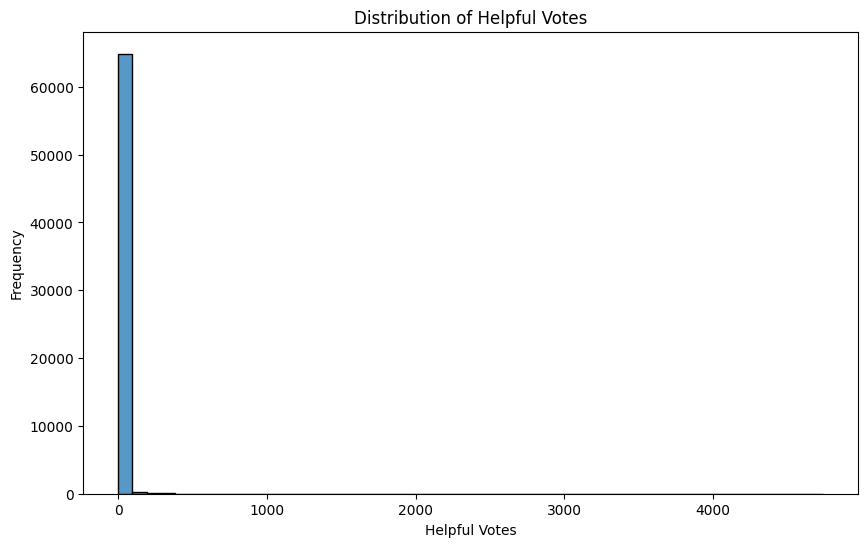

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df_merged_full['Helpful Votes'], bins=50, kde=False)
plt.title('Distribution of Helpful Votes')
plt.xlabel('Helpful Votes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
total = len(df_merged_full)
zero_count = (df_merged_full['Helpful Votes'] == 0).sum()
zero_ratio = zero_count / total

print(f"전체 데이터 수: {total}")
print(f"Helpful Votes가 0인 데이터 수: {zero_count}")
print(f"0인 데이터 비율: {zero_ratio:.2%}")

전체 데이터 수: 65323
Helpful Votes가 0인 데이터 수: 47358
0인 데이터 비율: 72.50%


In [ ]:
print(df_merged_full['Helpful Votes'].describe())

count    65323.000000
mean         3.898244
std         54.648607
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       4742.000000
Name: Helpful Votes, dtype: float64


In [ ]:
mean_val = df_merged_full['Helpful Votes'].mean()
var_val = df_merged_full['Helpful Votes'].var()

print(f"평균: {mean_val}")
print(f"분산: {var_val}")
if var_val > mean_val:
    print("과산포(overdispersion) 상태로 음이항 모델 적용 가능성이 높음")
else:
    print("과산포 상태가 아니어서 음이항 모델이 적합하지 않을 수 있음")

평균: 3.8982441100378122
분산: 2986.470295287203
과산포(overdispersion) 상태로 음이항 모델 적용 가능성이 높음
